##### Grading Feedback

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- Students may use toPandas() to print the head of data frames.
- Students are responsible for reading the usage comments and understanding how to properly use the get_training_filename() function.  Runtime errors which result from incorrect usage of get_training_filename() shall result in a  point reduction.  
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.  Heavy weight operations that convert data to pandas or spark (like collect()) will result in a point reduction.__

In [1]:
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
from pyspark.sql.functions import isnan, isnull, when, count, col
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.mllib.stat import Statistics
from pyspark.ml import feature
from pyspark.ml import clustering
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline
import seaborn as sns
from pyspark.ml.feature import StandardScaler
from math import exp, log10, fabs, atan, log
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
import requests
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.classification import GBTClassifier

### Wine Analysis
I'm a big fan of wine and would love to use visualizations, machine learning, and inference to learn more about the characteristics of a good wine and predict good wines.  Unfortunately I'm too busy (and lazy) to do the analysis myself but I do have just under 60 trained data scientests at my disposal to do the research for me.  The data set contains the following columns:<br>

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [2]:
# Do not delete or change this cell

# grading import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Question 1 Data Wrangling: (10 pts)
Read the winequality-red.csv data set into a spark data frame named wine_df.  Use the get_training_filename function provided above to determine the appropriate file path based on the platform on which you are running. Check the resulting data frame for NA / NAN values and deal with these problems appropriately.  Note that the target variable has 10 classes.  Convert the 10 classes into 2 classes.  If the target variable is greater than or equal to 7, replace the label with a 1 indicating good wine.  If the target varible is less than 7, replace the label with a 0 indicating a lower quality wine.

In [3]:
# students shall create wine_df here
wine_df = spark.read.csv(get_training_filename('winequality-red.csv'), header=True, inferSchema=True)
wine_df = wine_df.select(fn.col('fixed acidity'),fn.col('volatile acidity'),fn.col('citric acid'),fn.col('residual sugar'),
        fn.col('chlorides'),fn.col('free sulfur dioxide'),fn.col('total sulfur dioxide'),fn.col('density'),fn.col('pH'),
       fn.col('sulphates'),fn.col('alcohol'),
    fn.when(fn.col('quality')>=7,1).otherwise(0).alias('quality'))
rolled_up = wine_df.select(fn.sum(fn.isnan('fixed acidity').cast('int')).alias('sum_col1'),fn.sum(fn.isnan('volatile acidity').cast('int')).alias('sum_col2'),
fn.sum(fn.isnan('citric acid').cast('int')).alias('sum_col3'),fn.sum(fn.isnan('residual sugar').cast('int')).alias('sum_col4'),
fn.sum(fn.isnan('chlorides').cast('int')).alias('sum_col5'),fn.sum(fn.isnan('free sulfur dioxide').cast('int')).alias('sum_col6'),
fn.sum(fn.isnan('total sulfur dioxide').cast('int')).alias('sum_col7'),fn.sum(fn.isnan('density').cast('int')).alias('sum_col8'),
fn.sum(fn.isnan('pH').cast('int')).alias('sum_col9'),fn.sum(fn.isnan('sulphates').cast('int')).alias('sum_col10'),
fn.sum(fn.isnan('alcohol').cast('int')).alias('sum_col11'),fn.sum(fn.isnan('quality').cast('int')).alias('sum_col12'))
rolled_up.show()

rolled_up2 = wine_df.select(fn.sum(fn.isnull('fixed acidity').cast('int')).alias('sum_col1'),fn.sum(fn.isnull('volatile acidity').cast('int')).alias('sum_col2'),
fn.sum(fn.isnull('citric acid').cast('int')).alias('sum_col3'),fn.sum(fn.isnull('residual sugar').cast('int')).alias('sum_col4'),
fn.sum(fn.isnull('chlorides').cast('int')).alias('sum_col5'),fn.sum(fn.isnull('free sulfur dioxide').cast('int')).alias('sum_col6'),
fn.sum(fn.isnull('total sulfur dioxide').cast('int')).alias('sum_col7'),fn.sum(fn.isnull('density').cast('int')).alias('sum_col8'),
fn.sum(fn.isnull('pH').cast('int')).alias('sum_col9'),fn.sum(fn.isnull('sulphates').cast('int')).alias('sum_col10'),
fn.sum(fn.isnull('alcohol').cast('int')).alias('sum_col11'),fn.sum(fn.isnull('quality').cast('int')).alias('sum_col12'))
rolled_up2.show()

### THE DATAFRAME has no NA/NAN/NULL values in any of the 12 columns as shown below

+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+
|sum_col1|sum_col2|sum_col3|sum_col4|sum_col5|sum_col6|sum_col7|sum_col8|sum_col9|sum_col10|sum_col11|sum_col12|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+
|       0|       0|       0|       0|       0|       0|       0|       0|       0|        0|        0|        0|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+

+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+
|sum_col1|sum_col2|sum_col3|sum_col4|sum_col5|sum_col6|sum_col7|sum_col8|sum_col9|sum_col10|sum_col11|sum_col12|
+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+
|       0|       0|       0|       0|       0|       0|       0|       0|       0|        0|   

In [4]:
# grading cell: students shall print the head and shape of wine_df here
print("Shape of wine_df is: ",(wine_df.count(), len(wine_df.columns)))
wine_df.toPandas().head()

Shape of wine_df is:  (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [5]:
# grading cell: students shall prove that there are no NA / NAN values in the wine_df here

print(rolled_up.select(fn.col('sum_col1')+fn.col('sum_col2')+fn.col('sum_col3')+fn.col('sum_col4')
+fn.col('sum_col5')+fn.col('sum_col6')+fn.col('sum_col7')+fn.col('sum_col8')+fn.col('sum_col9')
+fn.col('sum_col10')+fn.col('sum_col11')+fn.col('sum_col12').alias('Total_NANs')).collect()[0][0])
     
rolled_up2.select(fn.col('sum_col1')+fn.col('sum_col2')+fn.col('sum_col3')+fn.col('sum_col4')
+fn.col('sum_col5')+fn.col('sum_col6')+fn.col('sum_col7')+fn.col('sum_col8')+fn.col('sum_col9')
+fn.col('sum_col10')+fn.col('sum_col11')+fn.col('sum_col12').alias('Total_NULLs')).collect()[0][0]

0


0

##### Grading feedback cell

# Question 2 Visualizations (10 pts)
I am interested to know more about the data set.  Create one or more visualizations that summarize the data.  Write a short description that helps me understand the visualizations.  Tell me something interesting or surprising about the data.

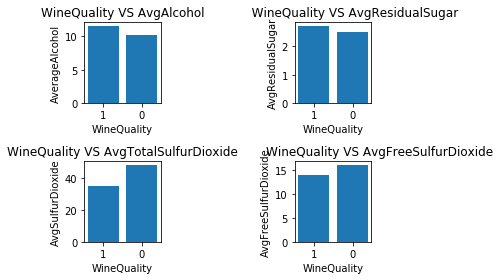

In [6]:
# your code here
wine_df_agg = (wine_df.groupBy("quality").agg(fn.mean("fixed acidity"),fn.mean("volatile acidity"),fn.mean("citric acid"),
                    fn.mean("residual sugar"),fn.mean("chlorides"),fn.mean("free sulfur dioxide"),fn.mean("total sulfur dioxide"),
                    fn.mean("density"),fn.mean("pH"),fn.mean("sulphates"),fn.mean("alcohol"))).toPandas()
x_ax = list(wine_df_agg['quality'])
x_ax = [str(i) for i in x_ax]
y1 = list(wine_df_agg['avg(alcohol)'])
y2 = list(wine_df_agg['avg(residual sugar)'])
y3 = list(wine_df_agg['avg(total sulfur dioxide)'])
y4 = list(wine_df_agg['avg(free sulfur dioxide)'])
y = [y1,y2,y3,y4]
figure, axes = plt.subplots(nrows=2, ncols=2)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.9, hspace=0.9)
axes[0, 0].bar(x_ax, y[0])
axes[0, 0].set_title('WineQuality VS AvgAlcohol')
axes[0, 0].set_xlabel('WineQuality')
axes[0, 0].set_ylabel('AverageAlcohol')

axes[0, 1].bar(x_ax, y[1])
axes[0, 1].set_title('           WineQuality VS AvgResidualSugar')
axes[0, 1].set_xlabel('WineQuality')
axes[0, 1].set_ylabel('AvgResidualSugar')

axes[1, 0].bar(x_ax, y[2])
axes[1, 0].set_title('WineQuality VS AvgTotalSulfurDioxide')
axes[1, 0].set_xlabel('WineQuality')
axes[1, 0].set_ylabel('AvgSulfurDioxide')

axes[1, 1].bar(x_ax, y[3])
axes[1, 1].set_title('                        WineQuality VS AvgFreeSulfurDioxide')
axes[1, 1].set_xlabel('WineQuality')
axes[1, 1].set_ylabel('AvgFreeSulfurDioxide')

figure.tight_layout()
display()

Your short description here:<br>
From the above bar graphs with Wine Quality versus other numeric variables, we can observe that the AVERAGE "free sulfur dioxide" and AVERAGE "total sulfur dioxide is higher for lower quality wines" whereas on the other hand, AVERAGE "alcohol", and "residual sugar" are higher for good wines.

##### Grading Feedback

# Random Forest

# Question 3: (10 pts)
Create a spark RandomForestClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [7]:
# Your code here
rf_training_df, rf_validation_df = wine_df.randomSplit([0.7, 0.3],12343)
va = VectorAssembler().setInputCols(rf_training_df.columns[0:11]).setOutputCol('features')
rf = RandomForestClassifier(labelCol='quality')
rf_pipeline = Pipeline(stages=[va, rf]).fit(rf_training_df)

bce = BinaryClassificationEvaluator(labelCol='quality')
bce.evaluate(rf_pipeline.transform(rf_validation_df))

0.8847796762589949

##### Grading Feedback

# Question 4: (10 pts)
Use spark RandomForestClassifier, ParamGridBuilder, and CrossValidator objects to perform a random forest grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default random forest model above.  You are free to choose any hyper parameters you want in your grid search.  You should be able to achieve an AUC score around / above 88%. 

In [8]:
# Your grid search code here
rf_training_df, rf_validation_df = wine_df.randomSplit([0.7, 0.3],12343)
va = VectorAssembler().setInputCols(rf_training_df.columns[0:11]).setOutputCol('features')
rf = RandomForestClassifier(labelCol='quality',featuresCol="features")
rf_pipeline = Pipeline(stages=[va, rf])

#grid = (ParamGridBuilder().addGrid(rf.featureSubsetStrategy, ['auto','sqrt','log2']).addGrid(rf.impurity,['GINI','entropy']).addGrid(rf.numTrees, [80,120,150]).build())
grid = (ParamGridBuilder().addGrid(rf.featureSubsetStrategy, ['auto']).addGrid(rf.impurity,['GINI']).addGrid(rf.numTrees, [80]).build())
evaluator = BinaryClassificationEvaluator(labelCol = 'quality',metricName = 'areaUnderROC')
cv1 = CrossValidator(estimator=rf_pipeline, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv1 = cv1.fit(rf_training_df)

bce = BinaryClassificationEvaluator(labelCol='quality')
bce.evaluate(fitted_cv1.bestModel.transform(rf_validation_df))

0.8941471822542001

##### Grading Feedback

# Question 5 (10 pts)
Extract the cross validation AUC score and specific hyper parameters used from the grid search above.  Create a pandas dataframe where the first column is the grid parameter name and the 2nd colum is the grid parameter value.  Make the last row of the pandas data frame the resulting AUC score.  Print the pandas data frame.  Describe in words in the markdown cell below what specific parameters you used in your grid and what those parameters do in the model.  For example, if you specified impurity in your grid, describe what impurity does in the random forest.  Keep the descriptions brief and at a high level, I'm just trying to see if you understand the high level concept of what the tuning parameter does.

In [9]:
# Print the pandas data frame here
dict1 = {'grid_paramter_name': ['featureSubsetStrategy','impurity','numTrees','Cross Validator AUC'], 
         'grid_parameter_value': [fitted_cv1.bestModel.stages[1].getOrDefault('featureSubsetStrategy'),
                                  fitted_cv1.bestModel.stages[1].getOrDefault('impurity'),
                                  fitted_cv1.bestModel.stages[1].getOrDefault('numTrees'),
                                  max(fitted_cv1.avgMetrics)]}
best_model_parameters_df = pd.DataFrame.from_dict(dict1)
best_model_parameters_df

,grid_paramter_name,grid_parameter_value
0,featureSubsetStrategy,auto
1,impurity,GINI
2,numTrees,80
3,Cross Validator AUC,0.870597


Write your grid search parameter descriptions here:

The grid parameters, I used in the above question are 'featureSubsetStrategy','impurity' and 'numTrees'. The first paramter featureSubsetStrategy is to specify the method in which the Random Forest should select the required number of features to be considered at each spliting node of a decision tree. This hyperparameter takes values such as 'auto', 'log2' and 'sqrt' to decide the number of features required to build each of the decision trees by either automatically taking the required number of features or by taking log to the base 2 of the total number of features or by taking square root of the total number of features. 
The second hyperparameter 'impurity' is to specify the measure that needs to be used to decide the splitting attribute at each node. For example if 'Entropy' is chosen as the hyperparameter value, then, if a splitting attribute 'A' is resulting in the child node being more pure and thereby having lower entropy in comparison to the splitting attribute 'B', then the attribute 'A' will be chosen to split at that node as it is resulting in lower entropy of the child node and thus higher purity of the child node. The goal is to reduce the impurity and entropy as much as possible when traversing from the root node to leaf nodes by reducing the occurences of any given class in the lower nodes.
The third hyperparamter 'numTrees' is simply used to specify the required number of Decision Trees in the hyperparameter.

##### Grading Feedback

# Question 6: 5 pts
Create a pandas dataframe containing 2 columns: `feature` and `importance`.  Load the feature column with the dataset feature names and the 2nd column with the feature importances as determined by the best model produced by the grid search above.  Sort the dataframe by `importance` in descending order. In the markdown cell, tell me the 3 features that are most important to predicting a good wine.

In [10]:
# Your code here
pd.DataFrame(list(zip(wine_df.columns[0:11], fitted_cv1.bestModel.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

,feature,importance
10,alcohol,0.287217
9,sulphates,0.155402
1,volatile acidity,0.108147
2,citric acid,0.069579
0,fixed acidity,0.069507
4,chlorides,0.064766
7,density,0.062885
6,total sulfur dioxide,0.060785
3,residual sugar,0.046305
8,pH,0.038276


Your feature importance comments here.
The 3 features that are most important in predicting a good wine are 'alcohol','volatile acidity' and 'sulphates' because these 3 features have the highest variable importance.

# Question 7:  10 pts.
Print any of the trees in the forest from the final model.  Copy the printed text to the tree printout markdown cell below and retain the same formatting and indentation as the printout so it's easy for the graders to view the data.  Add comments to the markdown cell below describing how the root node is split:  Describe 2 things in the markdown cells below.  1) What specific predictor variable is being split and what is the value that determines the left / right split.  2) The top level split indicates the most important predictor in the data set.  Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above. <br>

In [11]:
# your code here
print(fitted_cv1.bestModel.stages[1].trees[0].toDebugString)

DecisionTreeClassificationModel (uid=dtc_8a4d05b406a6) of depth 5 with 37 nodes
  If (feature 2 <= 0.315)
   If (feature 7 <= 0.995295)
    If (feature 4 <= 0.0665)
     If (feature 6 <= 18.5)
      Predict: 0.0
     Else (feature 6 > 18.5)
      If (feature 5 <= 33.5)
       Predict: 0.0
      Else (feature 5 > 33.5)
       Predict: 1.0
    Else (feature 4 > 0.0665)
     If (feature 10 <= 11.975)
      Predict: 0.0
     Else (feature 10 > 11.975)
      If (feature 1 <= 0.435)
       Predict: 1.0
      Else (feature 1 > 0.435)
       Predict: 0.0
   Else (feature 7 > 0.995295)
    If (feature 4 <= 0.0625)
     If (feature 0 <= 6.85)
      If (feature 0 <= 6.65)
       Predict: 0.0
      Else (feature 0 > 6.65)
       Predict: 1.0
     Else (feature 0 > 6.85)
      Predict: 0.0
    Else (feature 4 > 0.0625)
     Predict: 0.0
  Else (feature 2 > 0.315)
   If (feature 7 <= 0.9961800000000001)
    If (feature 9 <= 0.725)
     If (feature 0 <= 8.850000000000001)
      If (feature 2 <= 0.575

##### Grading Feedback

Paste the tree printout in this cell:
DecisionTreeClassificationModel (uid=dtc_f65cfdcff213) of depth 5 with 33 nodes
```
  If (feature 2 <= 0.315)
   If (feature 7 <= 0.995295)
    If (feature 4 <= 0.0665)
     If (feature 6 <= 18.5)
      Predict: 0.0
     Else (feature 6 > 18.5)
      If (feature 5 <= 33.5)
       Predict: 0.0
      Else (feature 5 > 33.5)
       Predict: 1.0
    Else (feature 4 > 0.0665)
     If (feature 10 <= 11.975)
      Predict: 0.0
     Else (feature 10 > 11.975)
      If (feature 1 <= 0.435)
       Predict: 1.0
      Else (feature 1 > 0.435)
       Predict: 0.0
   Else (feature 7 > 0.995295)
    If (feature 4 <= 0.0625)
     If (feature 0 <= 6.85)
      If (feature 0 <= 6.65)
       Predict: 0.0
      Else (feature 0 > 6.65)
       Predict: 1.0
     Else (feature 0 > 6.85)
      Predict: 0.0
    Else (feature 4 > 0.0625)
     Predict: 0.0
  Else (feature 2 > 0.315)
   If (feature 7 <= 0.9961800000000001)
    If (feature 9 <= 0.725)
     If (feature 0 <= 8.850000000000001)
      If (feature 2 <= 0.575)
       Predict: 0.0
      Else (feature 2 > 0.575)
       Predict: 1.0
     Else (feature 0 > 8.850000000000001)
      If (feature 9 <= 0.515)
       Predict: 0.0
      Else (feature 9 > 0.515)
       Predict: 1.0
    Else (feature 9 > 0.725)
     Predict: 1.0
   Else (feature 7 > 0.9961800000000001)
    If (feature 4 <= 0.0735)
     If (feature 8 <= 3.3449999999999998)
      If (feature 8 <= 3.145)
       Predict: 0.0
      Else (feature 8 > 3.145)
       Predict: 1.0
     Else (feature 8 > 3.3449999999999998)
      Predict: 0.0
    Else (feature 4 > 0.0735)
     Predict: 0.0
```

##### Grading Feedback

What specific predictor variable is being split and what is the value that determines the left / right split:

The feature 2 which is 'citric acid' is being used to split at the root node. The value 0.315 is the one that determines the left/right split. All the rows with 'citric acid' value <= 0.315 move to the left side of the tree and the rows with 'citric acid' value > 0.315 move to the right side of the tree.

##### Grading Feedback

Explain why the top level predictor in your printed tree can be different that the top level predictor from the cross validated model above:

The top level predictor or the splitting attribute at the root node in any randomly selected tree can be different from the most important predictor of the best fitted cross validated model because this random forest model automatically picks a selected number of sample of features for splitting at every node and hence all the features of the training dataset are not used to split at every node. Hence the most important feature may not be selected in the sample of features to be considered for splitting in a particular node.

##### Grading Feedback

# Question 8:  10 pts.
Create a spark GBTClassifier using all default parameters.  Train the model and calculate the AUC using a BinaryClassificationEvaluator.

In [12]:
# Your Code Here
gb_training_df, gb_validation_df = wine_df.randomSplit([0.7, 0.3],12343)
va = VectorAssembler().setInputCols(gb_training_df.columns[0:11]).setOutputCol('features')

gbt = GBTClassifier(labelCol='quality',featuresCol="features")
gbt_pipeline = Pipeline(stages=[va, gbt]).fit(gb_training_df)

bce = BinaryClassificationEvaluator(labelCol='quality')
bce.evaluate(gbt_pipeline.transform(gb_validation_df))

0.8856602218225438

##### Grading Feedback

# Question 9:  10 pts.
Use spark GBTClassifier, ParamGridBuilder, and CrossValidator objects to perform a GBT grid search.  Use 3 fold cross validation and a BinaryClassificationEvaluator to evaluate the results.  The goal is to see if you can improve upon the AUC score produced by the default GBT model and the random forest model above.  You are free to experiment with any search parameters you wish.  It is also okay to experiment with maxIter and stepSize outside of the grid if you wish as long as you comment what you are doing.

In [13]:
# Your Code Here
gbt_pipeline = Pipeline(stages=[va, gbt])

grid = (ParamGridBuilder().addGrid(gbt.featureSubsetStrategy, ['auto']).addGrid(gbt.stepSize,[0.1]).addGrid(gbt.maxDepth, [5]).addGrid(gbt.maxIter,[150]).build())
#grid = (ParamGridBuilder().addGrid(gbt.featureSubsetStrategy, ['auto','sqrt','log2']).addGrid(gbt.stepSize,[0.1,0.3,0.5]).addGrid(gbt.maxDepth, [5, 10, 15]).addGrid(gbt.maxIter, [80,110,150]).build())
evaluator = BinaryClassificationEvaluator(labelCol = 'quality',metricName = 'areaUnderROC')
cv2 = CrossValidator(estimator=gbt_pipeline, estimatorParamMaps=grid, evaluator=evaluator, numFolds = 3, seed = 65)
fitted_cv2 = cv2.fit(gb_training_df)

bce = BinaryClassificationEvaluator(labelCol='quality')
bce.evaluate(fitted_cv2.bestModel.transform(gb_validation_df))

0.8925359712230251

##### Grading Feedback

# Question 10 10 pts
Create a grid search summary pandas data frame for the GBT grid search exactly like you did in question 5 above.

In [14]:
# Your Code Here
dict2 = {'grid_paramter_name': ['featureSubsetStrategy','stepSize','maxDepth','maxIter','Cross Validator AUC'], 
         'grid_parameter_value': [fitted_cv2.bestModel.stages[1].getOrDefault('featureSubsetStrategy'),
                                  fitted_cv2.bestModel.stages[1].getOrDefault('stepSize'),
                                  fitted_cv2.bestModel.stages[1].getOrDefault('maxDepth'),
                                  fitted_cv2.bestModel.stages[1].getOrDefault('maxIter'),
                                  max(fitted_cv2.avgMetrics)]}
best_model_parameters_gbt_df = pd.DataFrame.from_dict(dict2)
best_model_parameters_gbt_df

,grid_paramter_name,grid_parameter_value
0,featureSubsetStrategy,auto
1,stepSize,0.1
2,maxDepth,5
3,maxIter,150
4,Cross Validator AUC,0.86595


##### Grading Feedback

Add search parameter comments here

Write your grid search parameter descriptions here:
The grid parameters, I used in the above question are 'featureSubsetStrategy','stepSize', 'maxDepth' and 'maxIter'. The first paramter featureSubsetStrategy is to specify the method in which the Gradient Boosting should select the required number of features to be considered at each spliting node of a decision tree. This hyperparameter takes values such as 'auto', 'log2' and 'sqrt' to decide the number of features required to build each of the decision trees by either automatically taking the required number of features or by taking log to the base 2 of the total number of features or by taking square root of the total number of features. 
The second hyperparameter 'stepSize' is to specify the learning rate of the gradient boosting model. In Gradient Boosting since the trees are built sequentially by trying to correct the preceeding errors, if the model learns too quickly, there is a risk of overfitting and hence this learning rate needs to be controlled by tuning this hyperparameter.
The third hyperparamter 'maxDepth' is to control the depth of each individual decision tree by pruning them with the maximum possible depth value. This hyperparameters is again used to control overfitting.
The fourth hyperparameter is 'maxIter' which is used to specify the number of iterations the gradient boosting algorithm must undergo, i.e. the number of trees that the model should produce. This parameter is also used to control for overfitting. Increase in the number of trees, i.e. the number of iterations will reduce variance.

# Question 11 (5 pts):
Create and print a pandas dataframe with the columns `feature` and `importance` just like question 6 above.  Also, compare the feature importances to random forest from question 6 above - how different or similar are the feature importances between GBT and random forest.

In [15]:
# Your code here
pd.DataFrame(list(zip(wine_df.columns[0:11], fitted_cv2.bestModel.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

,feature,importance
10,alcohol,0.123044
9,sulphates,0.108257
1,volatile acidity,0.106840
2,citric acid,0.104364
4,chlorides,0.102967
0,fixed acidity,0.093208
8,pH,0.083061
6,total sulfur dioxide,0.075547
7,density,0.071675
5,free sulfur dioxide,0.069258


Feature importance comments here:

The 3 most important features in determining the wine quality are alcohol, volatile acidity and sulphates, as these 3 features have the highest variable importance.  

Add feature importance comparison comments here:<br>

The 3 most important features are same between Random Forest and Gradient Boosting with only the order of importance differing between RF and GBT. Since both are decision tree based ensemble learning methods, the top 3 most important features will remain the same across the 2 methods. 

##### Grading Feedback